# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
!unzip Train_rev1.zip

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


In [3]:
data = pd.read_csv("Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
114308,69749419,Junior C Software Engineer ******** Farnborough,Junior C Software Engineer ******** Farnboro...,"Farnborough, Hampshire",Farnborough,NaN,permanent,Penguin Recruitment,IT Jobs,20000 - 25000/annum Corporate Benefits,22500,cv-library.co.uk,10.021315
68821,68800646,"Specialist Support Officer, Housing",The Citizens Advice service helps people resol...,West Midlands,West Midlands,full_time,contract,CITIZENS ADVICE,Charity & Voluntary Jobs,"Up to 34,031",34031,jobs.guardian.co.uk,10.435057
235391,72544872,Data Analyst,"Data Analyst Data extraction, Storage, Back u...","Cardiff, Wales",Cardiff,NaN,contract,Acorn Recruitment,IT Jobs,12 - 19/hour,29760,cv-library.co.uk,10.300954


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [4]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [5]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [6]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [7]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    for sample in data[col].values:
        token_counts.update(sample.split())

In [8]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

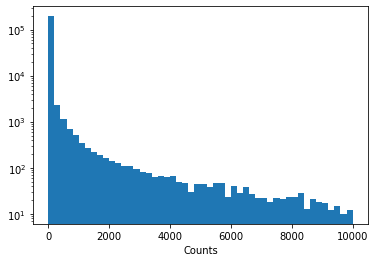

In [9]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [10]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token in token_counts if token_counts[token] >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [11]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [12]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [13]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [14]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [16]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [18]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [19]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[1569,  165,   88,   63,  340,  864, 1758, 3187, 5244,   82],
        [  70,  225, 3103,    6,   35,   86,  481,    1,    1,    1],
        [1000,  242, 1001,   88,  289,  299,  440,  883,   92,    1]],
       dtype=int32),
 'FullDescription': array([[1569,  165,   88,   63,  340,  864, 1758,   74,   82,   74],
        [  70,  225, 3103,    6,   35,   86,  481, 8830, 1314, 1464],
        [3199, 2241,  561,  177, 2719,   73,  561, 1414, 1000, 1001]],
       dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.998843, 10.389026, 10.915107], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [20]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [21]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        res = self.dense(F.relu(h))
        
        return res

In [22]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [23]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.

class JobDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        Same as TitleEncoder
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        res = self.dense(F.relu(h))
        
        return res

In [24]:
desc_encoder = JobDescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


In [25]:
print(generate_batch(data_train, 3)['Categorical'].shape)

(3, 3768)


__ Task 2.2__ Build one network ~~to rule them all~~

In [26]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = JobDescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categ_encoder = nn.Sequential(
            nn.Linear(3768, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.out = nn.Sequential(
            nn.Linear(136, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        res = self.out(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return res[:, 0]

In [27]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [29]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [30]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [31]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [32]:
num_epochs = 10
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [33]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	14.78151
	MAE:	34122.04417



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.72639
	MAE:	8140.82763



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.63306
	MAE:	7472.26729



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.50625
	MAE:	6494.00585



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.44369
	MAE:	5969.61181



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.37341
	MAE:	5616.65576



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.33146
	MAE:	5335.30176



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.31194
	MAE:	4972.65320



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.30508
	MAE:	4941.20925



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.27300
	MAE:	4674.39238



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25174
	MAE:	4540.20539



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25106
	MAE:	4339.22754



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25053
	MAE:	4553.00616



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22581
	MAE:	4183.58922



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22587
	MAE:	4288.80237



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20513
	MAE:	4168.45650



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20455
	MAE:	4151.23531



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19275
	MAE:	3985.30503



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18833
	MAE:	4055.03331



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17949
	MAE:	3879.90728





In [34]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.17949
	MAE:	3879.90728





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

In [35]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, use_dropout=False, use_bn=False):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.bn = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.dropout = nn.Dropout(p=0.2) if use_dropout else nn.Identity() 
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling() 
              
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.bn(h)
        h = self.pool1(h)
        h = self.dropout(h)
        res = self.dense(F.relu(h))
        
        return res

# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.

class JobDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64, use_dropout=False, use_bn=False):
        """ 
        Same as TitleEncoder
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        self.bn = nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.dropout = nn.Dropout(p=0.2) if use_dropout else nn.Identity() 

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.bn(h)
        h = self.pool1(h)
        h = self.dropout(h)
        res = self.dense(F.relu(h))
        
        return res


class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), use_dropout=False, use_bn=False):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64, use_dropout=use_dropout, use_bn=use_bn)
        self.desc_encoder = JobDescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.categ_encoder = nn.Sequential(
            nn.Linear(3768, 64),
            nn.ReLU(),
            nn.Linear(64, 8)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.out = nn.Sequential(
            nn.Linear(136, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categ_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        res = self.out(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return res[:, 0]

In [49]:
def train_model(num_epochs=10, use_dropout=False, use_bn=False):
    model = FullNetwork(use_dropout=use_dropout, use_bn=use_bn)
    model = model.to('cuda')
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    print(num_epochs)
    for epoch_i in range(num_epochs):
        
        print(f"{epoch_i} iter. Training:")
        train_loss = train_mae = train_batches = 0    
        model.train(True)
        
        for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

            title_ix = Variable(torch.cuda.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.cuda.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.cuda.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.cuda.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss += loss.data.cpu().numpy()
            train_mae += compute_mae(reference, prediction).data.cpu().numpy()
            train_batches += 1
        
        print("\tLoss:\t%.5f" % (train_loss / train_batches))
        print("\tMAE:\t%.5f" % (train_mae / train_batches))
        print('\n\n')
        
        print("Validation:")
        val_loss = val_mae = val_batches = 0
        model.train(False)
        
        with torch.no_grad():
            for batch in iterate_minibatches(data_val, shuffle=False):
                title_ix = Variable(torch.cuda.LongTensor(batch["Title"]))
                desc_ix = Variable(torch.cuda.LongTensor(batch["FullDescription"]))
                cat_features = Variable(torch.cuda.FloatTensor(batch["Categorical"]))
                reference = Variable(torch.cuda.FloatTensor(batch[target_column]))

                prediction = model(title_ix, desc_ix, cat_features)
                loss = compute_loss(reference, prediction)

                val_loss += loss.data.cpu().numpy()
                val_mae += compute_mae(reference, prediction).data.cpu().numpy()
                val_batches += 1

        print("\tLoss:\t%.5f" % (val_loss / val_batches))
        print("\tMAE:\t%.5f" % (val_mae / val_batches))
        print('\n\n')

    print("Final eval:")
    val_loss = val_mae = val_batches = 0

    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.cuda.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.cuda.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.cuda.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.cuda.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.cpu().numpy()
            val_mae += compute_mae(reference, prediction).data.cpu().numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')
        



In [44]:
# clear model
train_model()

10
Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	16.32411
	MAE:	33299.02600



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.74789
	MAE:	7751.54190



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.64331
	MAE:	7559.62134



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.52735
	MAE:	6703.33491



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.48722
	MAE:	6267.73838



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46131
	MAE:	7556.43662



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.36690
	MAE:	5462.78964



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32411
	MAE:	5335.26239



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.30827
	MAE:	5145.90781



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28283
	MAE:	5036.18260



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26171
	MAE:	4800.84303



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25618
	MAE:	4775.21823



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24509
	MAE:	4505.79757



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23527
	MAE:	4530.25476



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23214
	MAE:	4435.06193



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.26211
	MAE:	4303.62612



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21632
	MAE:	4264.19574



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20691
	MAE:	4356.25168



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21279
	MAE:	4242.04500



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19164
	MAE:	4163.11871



Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19164
	MAE:	4163.11871





In [45]:
# using bn
train_model(use_bn=True)

10
Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	10.43367
	MAE:	608451.24386



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.92275
	MAE:	12571.45126



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.72463
	MAE:	8749.49793



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.50736
	MAE:	6208.78978



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.48705
	MAE:	6529.34385



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.63035
	MAE:	5920.40367



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.35461
	MAE:	5446.95581



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32391
	MAE:	4725.56215



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.31592
	MAE:	5203.73749



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28665
	MAE:	4537.61604



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26304
	MAE:	4582.06995



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24679
	MAE:	4630.34620



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24177
	MAE:	4606.50592



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22772
	MAE:	4274.81173



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24257
	MAE:	4576.35504



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23405
	MAE:	4833.53750



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21983
	MAE:	4457.61390



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.20111
	MAE:	4290.12338



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20380
	MAE:	4167.39897



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24656
	MAE:	5333.86756



Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24656
	MAE:	5333.86756





In [48]:
# using dropout
train_model(use_dropout=True)

10
<built-in function iter> iter. Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	13.30794
	MAE:	37177.24205



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.68774
	MAE:	8545.31649



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.62112
	MAE:	7403.20891



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.48492
	MAE:	6416.64541



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.42735
	MAE:	6096.29941



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.38798
	MAE:	5126.93338



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.35260
	MAE:	5332.78765



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.32304
	MAE:	4767.74829



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.29655
	MAE:	5054.76680



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.28207
	MAE:	5189.54335



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.29473
	MAE:	4922.15321



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24814
	MAE:	4751.88056



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.25303
	MAE:	4699.84089



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22555
	MAE:	4293.74342



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.23945
	MAE:	4367.17695



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23616
	MAE:	4961.98738



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.21198
	MAE:	4285.40343



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19935
	MAE:	4087.16993



<built-in function iter> iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20406
	MAE:	4272.16169



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18681
	MAE:	3979.80655



Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18681
	MAE:	3979.80655





In [50]:
# using dropout and bn
train_model(use_bn=True, use_dropout=True)

10
0 iter. Training:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	10.29493
	MAE:	79661.85127



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.82669
	MAE:	8694.09633



1 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.73738
	MAE:	8833.38113



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.52217
	MAE:	7804.66228



2 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.47384
	MAE:	6651.43448



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35785
	MAE:	5421.27450



3 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.34232
	MAE:	5565.59052



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.29985
	MAE:	4823.08238



4 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.29811
	MAE:	5064.50025



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.26981
	MAE:	4484.69445



5 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.26397
	MAE:	4754.54924



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.24607
	MAE:	4360.18712



6 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24114
	MAE:	4484.95485



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22744
	MAE:	4306.98238



7 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24669
	MAE:	4497.93244



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21368
	MAE:	4309.14463



8 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22125
	MAE:	4381.29853



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22664
	MAE:	4085.89947



9 iter. Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19667
	MAE:	4148.32392



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18746
	MAE:	3955.32997



Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18746
	MAE:	3955.32997





### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

baseline - 4163 MAE

with batch_norm - 5333 MAE 

with dropout - 3979 MAE

with dropout and batchnorm - 3955 MAE